# Tutorial for simulated data
This tutorial provides step-by-step instructions for reproducing the simulation results presented in our paper. For each simulated dataset, we generated two modalities: one representing the transcriptome and the other representing the proteome. These datasets include multiple ground truth patterns—some shared between both modalities and others unique to a single modality. The simulated data are then used as input for our algorithm, which produces two types of outputs based on user preference.

# Domain clustering

/opt/anaconda3/envs/multiview/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/multiview/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/multiview/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Distribution

Building data and neighboring graphs...


100%|██████████| 1296/1296 [00:00<00:00, 128597.54it/s]


Starting training...


Epoch Loss:279.149: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


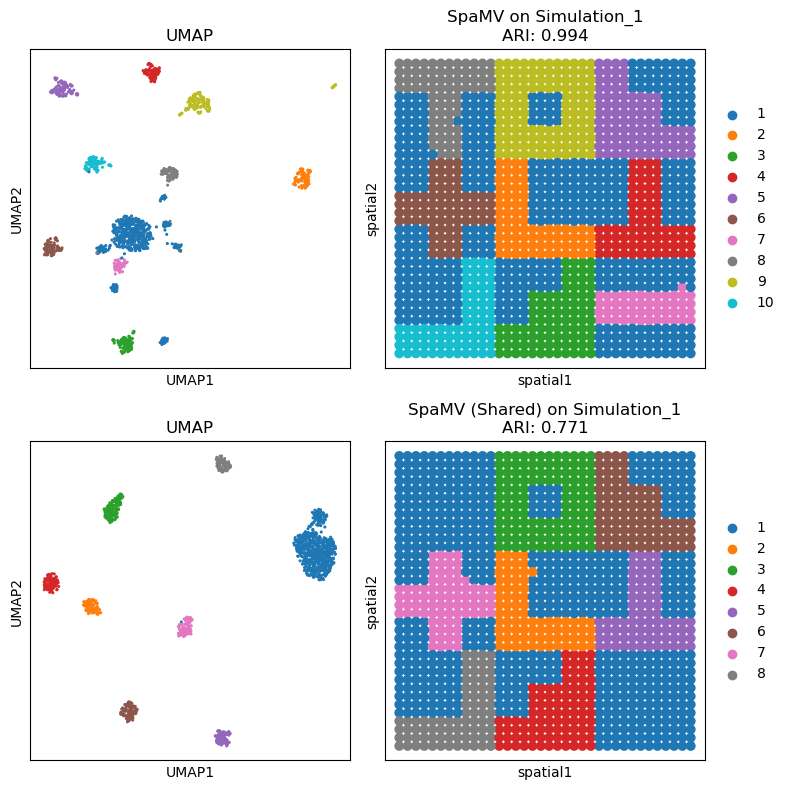

In [1]:
# SpaMV results
import anndata
from sklearn.metrics import adjusted_rand_score

from SpaMV_copy.spamv import SpaMV
from SpaMV_copy.utils import clr_normalize_each_cell, clustering
import scanpy as sc
import matplotlib.pyplot as plt

dataset = 'Simulation_1'

data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
sc.pp.normalize_total(data_rna)
sc.pp.log1p(data_rna)
sc.pp.pca(data_rna, n_comps=50)
data_rna = anndata.AnnData(data_rna.obsm['X_pca'], obs=data_rna.obs, obsm=data_rna.obsm)
data_pro = clr_normalize_each_cell(data_pro)
sc.pp.pca(data_pro, n_comps=50)
data_pro = anndata.AnnData(data_pro.obsm['X_pca'], obs=data_pro.obs, obsm=data_pro.obsm)

model = SpaMV([data_rna, data_pro], interpretable=False, max_epochs_stage1=100)
model.train()

data_rna.obsm['SpaMV'] = model.get_embedding()
clustering(data_rna, n_clusters=10, key='SpaMV')

data_rna.obsm['SpaMV (Shared)'] = data_rna.obsm['SpaMV'][:, :model.zs_dim]
if dataset == 'Simulation_1':
    n_clusters = 8
elif dataset == 'Simulation_2':
    n_clusters = 6
elif dataset == 'Simulation_3':
    n_clusters = 4
else:
    n_clusters = 10
clustering(data_rna, n_clusters=n_clusters, key='SpaMV (Shared)', add_key='SpaMV (Shared)')
fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 1 row, 2 columns

sc.pp.neighbors(data_rna, use_rep='SpaMV')
sc.tl.umap(data_rna)
sc.pl.umap(data_rna, color='SpaMV', ax=axes[0][0], show=False, legend_loc='none', s=20, title='UMAP')
sc.pl.embedding(data_rna, color='SpaMV', basis='spatial', s=200, show=False, title='SpaMV on {}\nARI: {:.3f}'.format(dataset, adjusted_rand_score(data_rna.obs['cluster'], data_rna.obs['SpaMV'])), ax=axes[0][1])
sc.pp.neighbors(data_rna, use_rep='SpaMV (Shared)')
sc.tl.umap(data_rna)
sc.pl.umap(data_rna, color='SpaMV (Shared)', ax=axes[1][0], show=False, legend_loc='none', s=20, title='UMAP')
sc.pl.embedding(data_rna, color='SpaMV (Shared)', basis='spatial', s=200, show=False, title='SpaMV (Shared) on {}\nARI: {:.3f}'.format(dataset, adjusted_rand_score(data_rna.obs['cluster'], data_rna.obs['SpaMV (Shared)'])), ax=axes[1][1])
plt.tight_layout()
plt.show()

# Interpretable dimension reduction

100%|██████████| 1296/1296 [00:00<00:00, 124031.81it/s]


Starting training...


Epoch Loss:1923.420: 100%|██████████| 200/200 [01:43<00:00,  1.92it/s]


merge Shared topic 2 and Shared topic 5


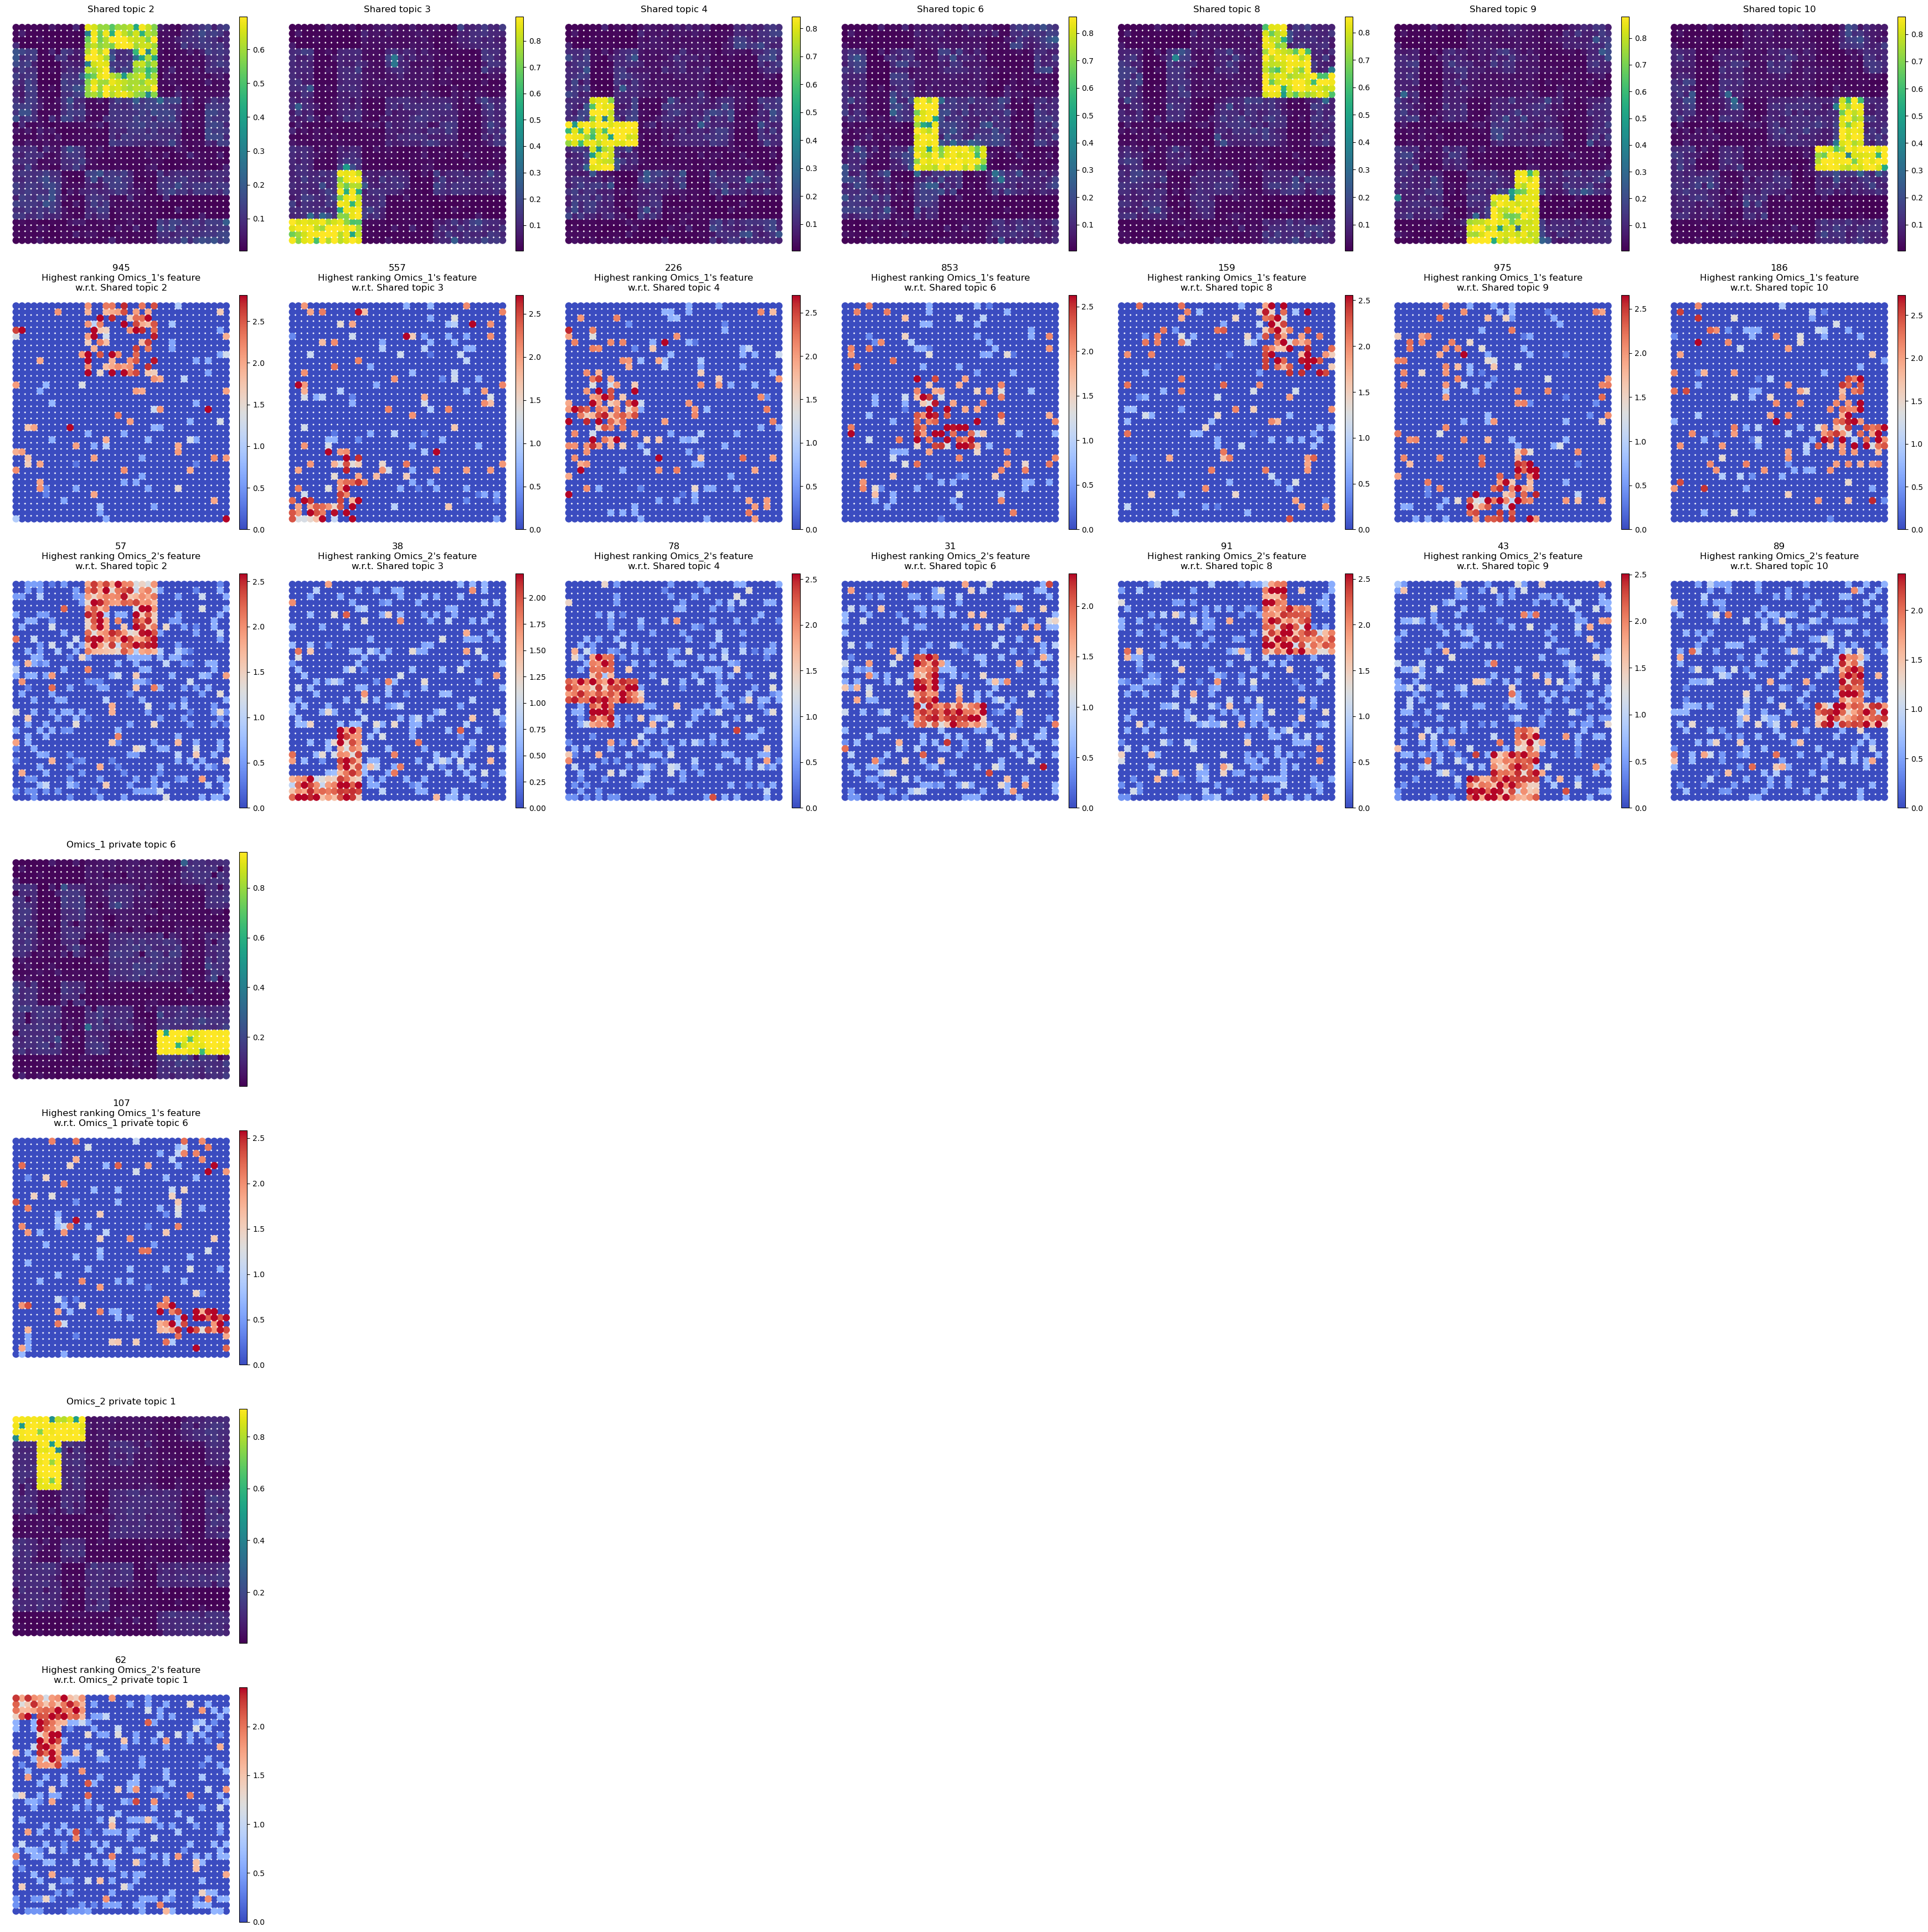

In [2]:
from SpaMV.spamv import SpaMV
from SpaMV.utils import clr_normalize_each_cell, plot_embedding_results
import scanpy as sc

dataset = 'Simulation_1'
data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
sc.pp.normalize_total(data_rna)
sc.pp.log1p(data_rna)
data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
data_pro = clr_normalize_each_cell(data_pro)
model = SpaMV([data_rna, data_pro], betas=[3, 3], neighborhood_embedding=5, interpretable=True, threshold_background=5, max_epochs_stage1=400, max_epochs_stage2=200)
model.train()

z, w = model.get_embedding_and_feature_by_topic(threshold=.1)
plot_embedding_results([data_rna, data_pro], model.omics_names, z, w, save=False, show=True, size=350)